<a href="https://colab.research.google.com/github/hanseungsoo13/Pytorch-Study/blob/main/LG_FastRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip /content/drive/MyDrive/crop_disease/train.zip # 자신의 train.zip 
!unzip /content/drive/MyDrive/crop_disease/test.zip
!mkdir model

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: test/65823/65823.csv    
  inflating: test/65823/65823.jpg    
   creating: test/65824/
  inflating: test/65824/65824.jpg    
  inflating: test/65824/65824.csv    
   creating: test/65825/
  inflating: test/65825/65825.csv    
  inflating: test/65825/65825.jpg    
   creating: test/65827/
  inflating: test/65827/65827.jpg    
  inflating: test/65827/65827.csv    
   creating: test/65828/
  inflating: test/65828/65828.jpg    
  inflating: test/65828/65828.csv    
   creating: test/65829/
  inflating: test/65829/65829.jpg    
  inflating: test/65829/65829.csv    
   creating: test/65830/
  inflating: test/65830/65830.jpg    
  inflating: test/65830/65830.csv    
   creating: test/65831/
  inflating: test/65831/65831.jpg    
  inflating: test/65831/65831.csv    
   creating: test/65832/
  inflating: test/65832/65832.jpg    
  inflating: test/65832/65832.csv    
   creating: test/65833/
  inflating: test/65833/65833.jpg    
  inflating: test

In [3]:
!pip install timm

     |████████████████████████████████| 431 kB 4.3 MB/s 


In [1]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import json
import cv2
import matplotlib.pyplot as plt

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import time



device = torch.device('cuda')

# score 계산
def accuracy_function(real, pred):                   # https://dacon.io/competitions/official/235870/codeshare/4146
    score = f1_score(real, pred, average='macro')
    return score

# torch model 저장
def model_save(model, score,  path):
    os.makedirs('model', exist_ok=True)
    torch.save({
        'model': model.state_dict(),
        'score': score
    }, path)

In [3]:
# 주어진 훈련 데이터 경로
train_csv = sorted(glob('train/*/*.csv'))
train_jpg = sorted(glob('train/*/*.jpg'))
train_json = sorted(glob('train/*/*.json'))


crops = []
diseases = []
risks = []
labels = []
bbox = []

# 훈련데이터 로드
for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
    
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)

        min_x = sample['annotations']['bbox'][0]['x']
        max_x = sample['annotations']['bbox'][0]['x']+sample['annotations']['bbox'][0]['w']
        min_y = sample['annotations']['bbox'][0]['y']
        max_y = sample['annotations']['bbox'][0]['y']+sample['annotations']['bbox'][0]['h']

        bbox.append([min_x,min_y,max_x,max_y])

def label_num(x):
  x_unique= sorted(np.unique(x))
  x_unique = {key:value for key,value in zip(x_unique, range(len(x_unique)))}
  x_labels = [x_unique[k] for k in x]
  return x_labels

labels_num=label_num(labels)
crops_num=label_num(crops)
diseases_num=label_num(diseases)
riskes_num=label_num(risks)


# 이미지 로드 함수 / 로드 후 (512, 384)로 사이즈 변환 ==> (원본 사이즈에서 width 384인 샘플이 많아서 (512, 384) 사이즈로 변환)
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (384, 512))
    return img

# 이미지 로드
imgs = [img_load(k) for k in tqdm(train_jpg)]


100%|██████████| 5767/5767 [00:46<00:00, 123.83it/s]


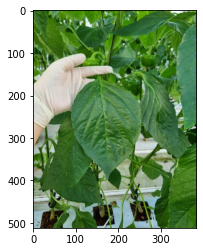

In [4]:
plt.imshow(imgs[0])

In [3]:
s = []

for csv_path in tqdm(train_csv):
  df = pd.read_csv(csv_path)
  s.append(df.shape)

100%|██████████| 5767/5767 [00:51<00:00, 112.10it/s]


In [5]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, bbox, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
        self.bbox=bbox
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode=='train':
            augmentation = random.randint(0,2)
            if augmentation==1:
                img = img[::-1].copy()
            elif augmentation==2:
                img = img[:,::-1].copy()
        img = transforms.ToTensor()(img)
        if self.mode=='test':
            return img
        
        label = self.labels[idx]
        box = self.bbox[idx]
        #area = (box[:, 3] - box[:, 1]) * (box[:, 2] - box[:, 0])
        target={}
        target["boxes"]=torch.Tensor(box).float().unsqueeze(0)
        target['labels']=torch.as_tensor(label, dtype=torch.int64).unsqueeze(0)
        #target['area']=area
        return img,target
        
    def collate_fn(self, batch):
        return tuple(zip(*batch))


class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=25)
        
    def forward(self, x):
        x = self.model(x)
        return x    

In [6]:
# KFold
folds = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, valid_idx in kf.split(imgs):
    folds.append((train_idx, valid_idx))
fold=0
train_idx, valid_idx = folds[fold]

batch_size = 4
epochs = 30


# Train
train_dataset = Custom_dataset(np.array(imgs)[train_idx], np.array(labels_num)[train_idx],[bbox[i] for i in train_idx], mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=train_dataset.collate_fn,pin_memory=True, num_workers=8)

# Validation 
valid_dataset = Custom_dataset(np.array(imgs)[valid_idx], np.array(labels_num)[valid_idx],[bbox[i] for i in valid_idx], mode='valid')
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, collate_fn=valid_dataset.collate_fn,pin_memory=True, num_workers=8)

In [7]:
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [8]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 25

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [9]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{m[0]: torch.as_tensor(m[1]).to(device) for m in t.items()}for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses
    
@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{m[0]: torch.as_tensor(m[1]).to(device) for m in t.items()}for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [10]:
!pip install -qU torch_snippets
from torch_snippets import *

In [11]:
n_epochs = 10
log = Report(n_epochs)

In [ ]:
for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(valid_loader)
    for ix,inputs in enumerate(valid_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 0.706	trn_loss: 0.146	trn_loc_loss: 0.080	trn_regr_loss: 0.042	trn_objectness_loss: 0.001	trn_rpn_box_reg_loss: 0.023	(2475.29s - 32573.54s remaining)

In [20]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16) # output의 bounding box
    labels = np.array([i for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy() # output bounding box 의 confidence score
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05) # nms 수행
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


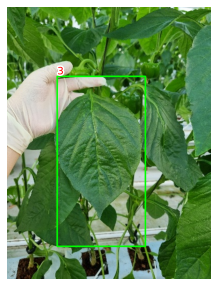

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


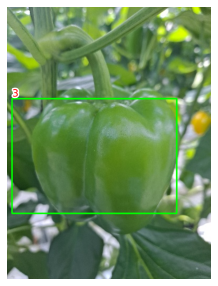

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


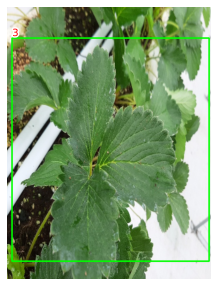

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


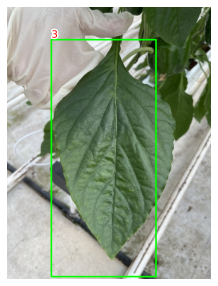

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


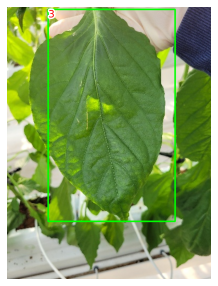

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


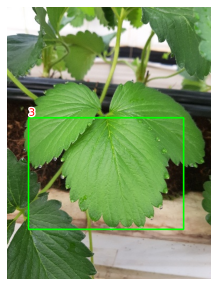

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


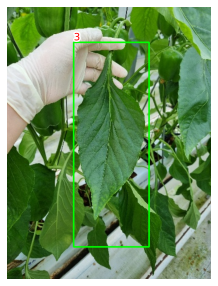

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


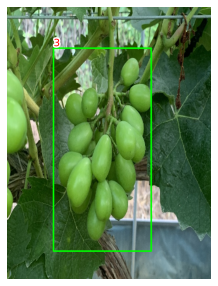

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


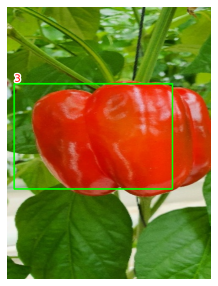

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


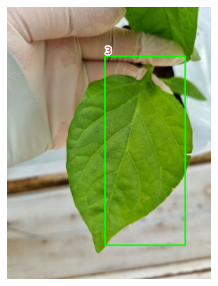

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


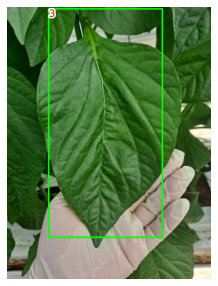

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


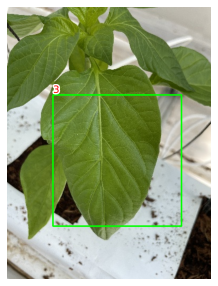

In [51]:
model.eval()
for ix, (images, targets) in enumerate(valid_loader):
    if ix==3: break
    images = [im.to(device) for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)

In [ ]:
model = Network().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 



best=0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = accuracy_function(train_y, train_pred)
    
    model.eval()
    valid_loss = 0
    valid_pred=[]
    valid_y=[]
    with torch.no_grad():
        for batch in (valid_loader):
            x = torch.tensor(batch[0], dtype=torch.float32, device=device)
            y = torch.tensor(batch[1], dtype=torch.long, device=device)
            with torch.cuda.amp.autocast():
                pred = model(x)
            loss = criterion(pred, y)
            valid_loss += loss.item()/len(valid_loader)
            valid_pred += pred.argmax(1).detach().cpu().numpy().tolist()
            valid_y += y.detach().cpu().numpy().tolist()
        valid_f1 = accuracy_function(valid_y, valid_pred)
    if valid_f1>=best:
        best=valid_f1
        model_save(model, valid_f1, f'model/eff-b0.pth')
    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
    print(f'VALID    loss : {valid_loss:.5f}    f1 : {valid_f1:.5f}    best : {best:.5f}')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


epoch : 1/30    time : 109s/3165s
TRAIN    loss : 0.42929    f1 : 0.87948
VALID    loss : 0.20911    f1 : 0.94975    best : 0.94975
epoch : 2/30    time : 110s/3088s
TRAIN    loss : 0.13692    f1 : 0.95832
VALID    loss : 0.02175    f1 : 0.98905    best : 0.98905
epoch : 3/30    time : 109s/2952s
TRAIN    loss : 0.11592    f1 : 0.95889
VALID    loss : 0.05060    f1 : 0.97899    best : 0.98905
epoch : 4/30    time : 110s/2849s
TRAIN    loss : 0.06484    f1 : 0.97656
VALID    loss : 0.06656    f1 : 0.98376    best : 0.98905
epoch : 5/30    time : 109s/2737s
TRAIN    loss : 0.09598    f1 : 0.96849
VALID    loss : 0.10271    f1 : 0.96984    best : 0.98905
epoch : 6/30    time : 110s/2630s
TRAIN    loss : 0.08290    f1 : 0.97190
VALID    loss : 0.05287    f1 : 0.97997    best : 0.98905
epoch : 7/30    time : 109s/2515s
TRAIN    loss : 0.05443    f1 : 0.97890
VALID    loss : 0.03817    f1 : 0.97983    best : 0.98905
epoch : 8/30    time : 110s/2410s
TRAIN    loss : 0.04255    f1 : 0.98561
VA

In [ ]:
best_crops_model=torch.load('model/eff-b0.pth')

In [ ]:
# 주어진 평가 데이터 경로
test_csv = sorted(glob('test/*/*.csv'))
test_jpg = sorted(glob('test/*/*.jpg'))

In [ ]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (384, 512))
    return img

# 이미지 로드
test_imgs = [img_load(k) for k in tqdm(test_jpg)]

 38%|███▊      | 19611/51906 [02:33<04:45, 113.23it/s]

In [ ]:
def predict(dataset,model):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    training = False
    results = []
    answer = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = torch.tensor(torch.argmax(output, axis=-1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
        answer.extend(batch_item['label'])
    return results, answer

preds, answer = predict(val_dataloader,best_crops_model)